In [22]:
# =========================
# 1) IMPORTS & GLOBALS
# =========================
import os
os.environ["TF_USE_PLUGGABLE_DEVICE"] = "0"

import math, pathlib, datetime, json, random
import numpy as np
import tensorflow as tf

try:
    from tensorflow import keras
except Exception:
    import tf_keras as keras

from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter

SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)
print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [23]:
# =========================
# 2) PATHS & HYPERPARAMS
# =========================
DATA_ROOT = pathlib.Path("Data")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR  = DATA_ROOT / "test"
assert TRAIN_DIR.exists() and TEST_DIR.exists(), "Check Data/train and Data/test paths."

IMG_SIZE  = (224, 224)   # bump to 224 for more capacity
BATCH     = 32
VAL_SPLIT = 0.20
EPOCHS    = 60
LR        = 8e-4         # start LR (ReduceLROnPlateau will manage it)
WEIGHT_DECAY = 1e-4      # L2
DROP_RATE    = 0.2
AUTOTUNE  = tf.data.AUTOTUNE


In [24]:
# =========================
# 3) DATASETS
# =========================
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=VAL_SPLIT, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=VAL_SPLIT, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, shuffle=False, image_size=IMG_SIZE, batch_size=BATCH)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 5144 files belonging to 3 classes.
Using 4116 files for training.
Found 5144 files belonging to 3 classes.
Using 1028 files for validation.
Found 1288 files belonging to 3 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']


In [25]:
# =========================
# 4) PIPELINE & AUGMENTATION
# =========================
def prep(ds, training=False):
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.cache().prefetch(AUTOTUNE)

train_ds_p = prep(train_ds, training=True)
val_ds_p   = prep(val_ds)
test_ds_p  = prep(test_ds)

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.08),
], name="augment")

norm = layers.Rescaling(1./255)


In [26]:
# ===================================
# 5) CLASS DISTRIBUTION & WEIGHTS
# ===================================
def count_labels(ds):
    c = Counter()
    for _, y in ds:
        for k, v in Counter(y.numpy().tolist()).items():
            c[k] += v
    return c

train_counts = count_labels(train_ds)
val_counts   = count_labels(val_ds)
test_counts  = count_labels(test_ds)

def pretty(counts):
    tot = sum(counts.values())
    return {class_names[k]: (v, round(v/tot,3)) for k,v in sorted(counts.items())}

print("Train:", pretty(train_counts))
print("Val  :", pretty(val_counts))
print("Test :", pretty(test_counts))

def make_class_weights(counts):
    tot = sum(counts.values())
    return {k: tot / (len(counts)*v) for k, v in counts.items()}

class_weight = make_class_weights(train_counts)
print("Class weights:", {class_names[i]: round(w,3) for i,w in class_weight.items()})


Train: {'COVID19': (387, 0.094), 'NORMAL': (1022, 0.248), 'PNEUMONIA': (2707, 0.658)}
Val  : {'COVID19': (73, 0.071), 'NORMAL': (244, 0.237), 'PNEUMONIA': (711, 0.692)}
Test : {'COVID19': (116, 0.09), 'NORMAL': (317, 0.246), 'PNEUMONIA': (855, 0.664)}
Class weights: {'COVID19': 3.545, 'NORMAL': 1.342, 'PNEUMONIA': 0.507}


2025-11-10 00:22:22.387338: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
# =========================
# 6) CALLBACKS
# =========================
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, mode="min", restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

ckpt_dir = pathlib.Path("runs") / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=str(ckpt_dir / "litedensenet_best.keras"),
    monitor="val_loss", save_best_only=True, verbose=1)


In [28]:
# ======================================================
# 7) MODEL: LiteDenseNet-BC (+ SE), from scratch, offline
#    - growth rate k
#    - bottleneck 1x1 -> 3x3 (DenseNet "BC")
#    - transition layers with compression θ
#    - Squeeze-and-Excitation in dense unit
# ======================================================
def se_block(x, r=8):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(c//r, 8), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    s = layers.Reshape((1,1,c))(s)
    return layers.Multiply()([x, s])

def dense_unit(x, growth_rate, l2=WEIGHT_DECAY, drop=DROP_RATE):
    # bottleneck
    out = layers.BatchNormalization()(x)
    out = layers.Activation("relu")(out)
    out = layers.Conv2D(4*growth_rate, 1, use_bias=False,
                        kernel_regularizer=regularizers.l2(l2))(out)
    # 3x3 conv
    out = layers.BatchNormalization()(out)
    out = layers.Activation("relu")(out)
    out = layers.Conv2D(growth_rate, 3, padding="same", use_bias=False,
                        kernel_regularizer=regularizers.l2(l2))(out)
    out = se_block(out)
    if drop and drop > 0:
        out = layers.Dropout(drop)(out)
    # concatenate
    x = layers.Concatenate()([x, out])
    return x

def dense_block(x, layers_count, growth_rate):
    for _ in range(layers_count):
        x = dense_unit(x, growth_rate)
    return x

def transition_layer(x, compression=0.5, l2=WEIGHT_DECAY, drop=DROP_RATE):
    c = x.shape[-1]
    reduced = int(c * compression)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(reduced, 1, use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(x)
    if drop and drop > 0:
        x = layers.Dropout(drop)(x)
    x = layers.AveragePooling2D(2)(x)
    return x

def build_litedensenet(input_shape=IMG_SIZE+(3,), num_classes=num_classes,
                       growth_rate=24, block_layers=(6,12,24,16), compression=0.5):
    inputs = keras.Input(shape=input_shape)
    x = augment(inputs)
    x = norm(x)

    # stem
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # dense blocks
    for i, lc in enumerate(block_layers):
        x = dense_block(x, layers_count=lc, growth_rate=growth_rate)
        if i != len(block_layers)-1:
            x = transition_layer(x, compression=compression)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="LiteDenseNetBC_SE")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return model

model = build_litedensenet()
model.summary()


Model: "LiteDenseNetBC_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ augment[0][0]     │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ rescaling_7[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      6,144 │ activation_1[0][… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     20,736 │ activation_2[0][… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 24)        │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        200 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 24)        │        216 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 24)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 56, 56,    │          0 │ conv2d_2[0][0], 

 Total params: 4,062,089 (15.50 MB)

 Trainable params: 3,998,621 (15.25 MB)

 Non-trainable params: 63,468 (247.92 KB)

In [29]:
# =========================
# 8) TRAIN
# =========================
history = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, ckpt],
    class_weight=class_weight
)


Epoch 1/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6428 - loss: 1.9805
Epoch 1: val_loss improved from None to 3.37385, saving model to runs/checkpoints/litedensenet_best.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7602 - loss: 1.7395 - val_accuracy: 0.3823 - val_loss: 3.3739 - learning_rate: 8.0000e-04
Epoch 2/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8305 - loss: 1.5204
Epoch 2: val_loss did not improve from 3.37385
129/129 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.8440 - loss: 1.4691 - val_accuracy: 0.2237 - val_loss: 4.7788 - learning_rate: 8.0000e-04
Epoch 3/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8664 - loss: 1.3604
Epoch 3: val_loss did not improve from 3.37385
129/129 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8763 - loss: 1.3002 - val_accuracy: 0.0710 - val_loss: 10.0082 - learning_rate: 8.0000e-04
Epoch 4/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8819 - loss: 1.2316
Epoch 4: ReduceLROnPl

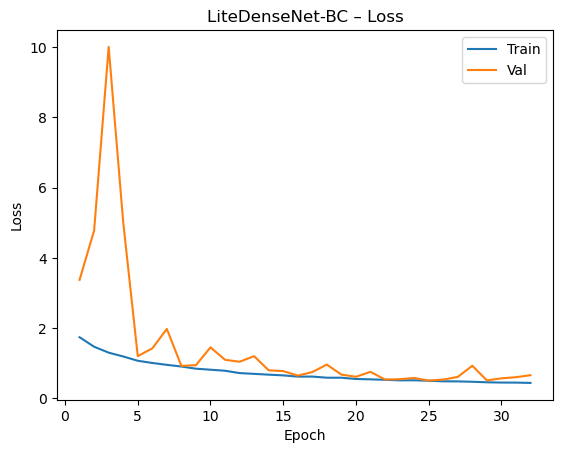

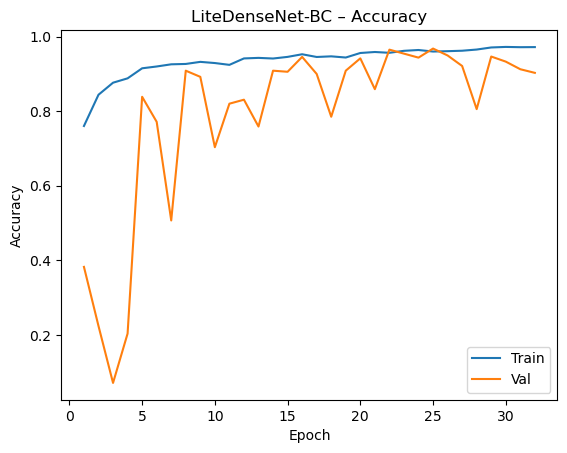

In [30]:
# =========================
# 9) PLOTS
# =========================
def plot_history(h, title="LiteDenseNet-BC"):
    acc, val_acc = h.history["accuracy"], h.history["val_accuracy"]
    loss, val_loss = h.history["loss"], h.history["val_loss"]
    xs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(xs, loss, label="Train")
    plt.plot(xs, val_loss, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} – Loss"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(xs, acc, label="Train")
    plt.plot(xs, val_acc, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} – Accuracy"); plt.legend(); plt.show()

plot_history(history)


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 402ms/step - accuracy: 0.9596 - loss: 0.5242
LiteDenseNet-BC – Test: {'accuracy': 0.9596273303031921, 'loss': 0.5241684317588806}

Macro  P/R/F1: 0.9592345541214765 0.9558974124095183 0.9574715191928093
Weighted P/R/F1: 0.9599924545737039 0.9596273291925466 0.9597641172074514

Classification report:
              precision    recall  f1-score   support

     COVID19     0.9912    0.9655    0.9782       116
      NORMAL     0.9136    0.9338    0.9236       317
   PNEUMONIA     0.9730    0.9684    0.9707       855

    accuracy                         0.9596      1288
   macro avg     0.9592    0.9559    0.9575      1288
weighted avg     0.9600    0.9596    0.9598      1288



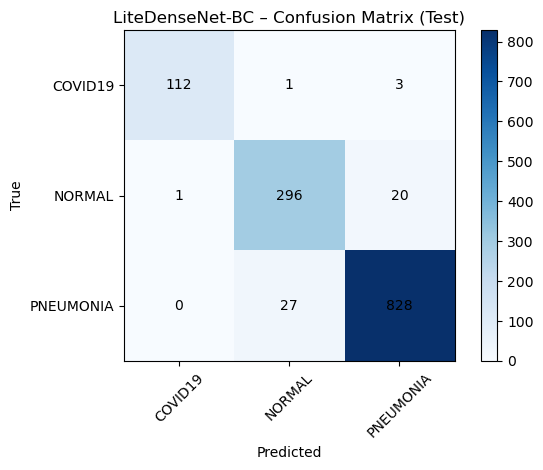

In [31]:
# =========================
# 10) TEST EVALUATION
# =========================
print("LiteDenseNet-BC – Test:", model.evaluate(test_ds_p, return_dict=True))

def predict_and_metrics(model, ds, label_names):
    y_true = np.concatenate([y.numpy() for _, y in ds], axis=0)
    y_prob = model.predict(ds, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print("\nMacro  P/R/F1:",
          precision_score(y_true, y_pred, average="macro"),
          recall_score(y_true, y_pred, average="macro"),
          f1_score(y_true, y_pred, average="macro"))
    print("Weighted P/R/F1:",
          precision_score(y_true, y_pred, average="weighted"),
          recall_score(y_true, y_pred, average="weighted"),
          f1_score(y_true, y_pred, average="weighted"))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title("LiteDenseNet-BC – Confusion Matrix (Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(label_names)), label_names, rotation=45)
    plt.yticks(range(len(label_names)), label_names)
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar(); plt.tight_layout(); plt.show()

predict_and_metrics(model, test_ds_p, class_names)
